In [16]:
import torch.nn as nn
import torch
import cv2
class DoubleConv(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_ch,out_ch,3,padding=1),#in_ch、out_ch是通道数
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True),
                nn.Conv2d(out_ch,out_ch,3,padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True)  
            )
    def forward(self,x):
        return self.conv(x)
 
 
class UNet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(UNet,self).__init__()
        self.conv1 = DoubleConv(in_ch,64)
        self.pool1 = nn.MaxPool2d(2)#每次把图像尺寸缩小一半
        self.conv2 = DoubleConv(64,128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128,256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256,512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512,1024)
        #逆卷积
        self.up6 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.conv6 = DoubleConv(1024,512)
        self.up7 = nn.ConvTranspose2d(512,256,2,stride=2)
        self.conv7 = DoubleConv(512,256)
        self.up8 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.conv8 = DoubleConv(256,128)
        self.up9 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.conv9 = DoubleConv(128,64)
        
        self.conv10 = nn.Conv2d(64,out_ch,1)
        
    
    def forward(self,x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6,c4],dim=1)#按维数1（列）拼接,列增加
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7,c3],dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8,c2],dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9,c1],dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        
        out = nn.Sigmoid()(c10)#化成(0~1)区间
        return out



In [25]:
import torch.utils.data as data
import os
import glob
import PIL.Image as Image
 
#data.Dataset:
#所有子类应该override__len__和__getitem__，前者提供了数据集的大小，后者支持整数索引，范围从0到len(self)
 
class LiverDataset(data.Dataset):
    #创建LiverDataset类的实例时，就是在调用init初始化
#     def __init__(self,root,transform = None,target_transform = None):#root表示图片路径
    def __init__(self):

        imgs = []
        
        dataset_path="./data/aisegmentcom-matting-human-datasets/clip_img/1803151818/clip_00000000"
        pathfile = glob.glob(os.path.join(dataset_path, '*.jpg'))
        dataset_path1 = "./data/aisegmentcom-matting-human-datasets/clip_img/1803151818/clip_00000001"
        pathfile_new = glob.glob(os.path.join(dataset_path1, '*.jpg'))
        pathfile.extend(pathfile_new)
        dataset_path1 = "./data/aisegmentcom-matting-human-datasets/clip_img/1803151818/clip_00000002"
        pathfile_new = glob.glob(os.path.join(dataset_path1, '*.jpg'))
        pathfile.extend(pathfile_new)
        
        for __num__, img_clip in enumerate(pathfile):
            img_mat = img_clip[0:43]+'matting/'+img_clip[52:63]+'matting_'+img_clip[68:-4]+'.png'
            imgs.append([img_clip, img_mat])
        self.imgs = imgs  

# '''
#         data_dir_clip = './data/aisegmentcom-matting-human-datasets/clip_img/1803151818/clip_00000000'
# #         data_dir_clip = '/home/vivi/sace/Google_ML_Camp/bk_rm/data/clip_img/1803151818/clip_00000000'

#         data_dir_mat = './data/aisegmentcom-matting-human-datasets/matting/1803151818/matting_00000000'
# #         data_dir_mat = '/home/vivi/sace/Google_ML_Camp/bk_rm/data/matting/1803151818/clip_00000000'

#         # n = len(os.listdir(data_dir_clip))
#         clip_imgs = os.listdir(data_dir_clip)
#         # mat_imgs = os.listdir(data_dir_mat)
    

#         for enu_num, img_clip in enumerate(clip_imgs):
#             img_mat = img_clip[0:-4]+'.png'
#             img_clip_path = data_dir_clip + '/' + img_clip
#             img_mat_path = data_dir_mat + '/' + img_mat
# #             img_clip_r = cv2.imread(img_clip_path)
# #             img_mat_r = cv2.imread(img_mat_path, cv2.IMREAD_UNCHANGED)
# #             Alpha = img_mat_r[:,:,3]
#             imgs.append([img_clip_path,img_mat_path])
# #             if enu_num==1:
# #                 break
 
#         self.imgs = imgs   
# '''       
    def __getitem__(self,index):
        x_path,y_path = self.imgs[index]
        img_x = cv2.imread(x_path)
        img_x = img_x.transpose((2,0,1))
        img_x = img_x[:,144:656, 44:556]
#         img_y = Image.open(y_path)
        img_y_ori = cv2.imread(y_path, cv2.IMREAD_UNCHANGED)
        img_y = img_y_ori[:,:,3]
        img_y = img_y[144:656, 44:556]
        img_y = (img_y>10)*1
#         if self.transform is not None:
#             img_x = self.transform(img_x)
#         if self.target_transform is not None:
#             img_y = self.target_transform(img_y)
        return img_x,img_y#返回的是图片
    
    
    def __len__(self):
        return len(self.imgs)#400,list[i]有两个元素，[img,mask]



In [26]:
import torch
from torchvision.transforms import transforms as T
import argparse #argparse模块的作用是用于解析命令行参数，例如python parseTest.py input.txt --port=8080
# import unet
from torch import optim
# from dataset import LiverDataset
from torch.utils.data import DataLoader
 
 
# 是否使用current cuda device or torch.device('cuda:0')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
 
x_transform = T.Compose([
    T.ToTensor(),
    # 标准化至[-1,1],规定均值和标准差
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])#torchvision.transforms.Normalize(mean, std, inplace=False)
])
# mask只需要转换为tensor
y_transform = T.ToTensor()
 
def train_model(model,criterion,optimizer,dataload,start_epoch = 0, num_epochs=1000):
    
    for epoch in range(start_epoch,num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dataset_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0 #minibatch数
        for x, y in dataload:# 分100次遍历数据集，每次遍历batch_size=4
            optimizer.zero_grad()#每次minibatch都要将梯度(dw,db,...)清零
            inputs = x.to(device, dtype=torch.float)
            labels = y.to(device, dtype = torch.float)
            labels = labels.unsqueeze(1)
            outputs = model(inputs)#前向传播
            loss = criterion(outputs, labels)#计算损失
            loss.backward()#梯度下降,计算出梯度
            optimizer.step()#更新参数一次：所有的优化器Optimizer都实现了step()方法来对所有的参数进行更新
            epoch_loss += loss.item()
            step += 1
            print("%d/%d,train_loss:%0.3f" % (step, dataset_size // dataload.batch_size, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss))
        if epoch%10 == 0:
            torch.save(model.state_dict(),'./model/weights_%d.pth' % epoch)# 返回模型的所有内容
            print("yeah! please see weights_{}.pth".format(epoch))
    return model
 
#训练模型
def train():
    model = UNet(3,1).to(device)
#     batch_size = args.batch_size
    continuerun=True
    latest_epoch = 20
    start_epoch=0
    if  continuerun:
        PATH = './model/weights_{}.pth'.format(latest_epoch)
        model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
        start_epoch = latest_epoch

    batch_size = arg_batch_size

    #损失函数
    criterion = torch.nn.BCELoss()
    #梯度下降
    optimizer = optim.Adam(model.parameters())#model.parameters():Returns an iterator over module parameters
    #加载数据集
#     liver_dataset = LiverDataset("data/train", transform=x_transform, target_transform=y_transform)
    liver_dataset = LiverDataset()
    dataloader = DataLoader(liver_dataset, batch_size=batch_size, shuffle=True,num_workers=1)
    # DataLoader:该接口主要用来将自定义的数据读取接口的输出或者PyTorch已有的数据读取接口的输入按照batch size封装成Tensor
    # batch_size：how many samples per minibatch to load，这里为4，数据集大小400，所以一共有100个minibatch
    # shuffle:每个epoch将数据打乱，这里epoch=10。一般在训练数据中会采用
    # num_workers：表示通过多个进程来导入数据，可以加快数据导入速度 
    train_model(model,criterion,optimizer,dataloader,start_epoch = start_epoch)
 
#测试
def test():
    model = UNet(3,1)
    model.load_state_dict(torch.load(args.weight,map_location='cpu'))
#     liver_dataset = LiverDataset("data/val", transform=x_transform, target_transform=y_transform)
    liver_dataset = LiverDataset()
    dataloaders = DataLoader(liver_dataset)#batch_size默认为1
    model.eval()
    import matplotlib.pyplot as plt
    plt.ion()
    with torch.no_grad():
        for x, _ in dataloaders:
            y=model(x)
            img_y=torch.squeeze(y).numpy()
            plt.imshow(img_y)
            plt.pause(0.01)
        plt.show()



In [27]:
torch.cuda.is_available()

False

In [28]:
arg_batch_size = 4
weight = './model'
train()

Epoch 20/999
----------
1/340,train_loss:0.082
2/340,train_loss:0.060


KeyboardInterrupt: 

# Test

In [65]:
import torch.nn as nn
import torch
import cv2
class DoubleConv(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_ch,out_ch,3,padding=1),#in_ch、out_ch是通道数
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True),
                nn.Conv2d(out_ch,out_ch,3,padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True)  
            )
    def forward(self,x):
        return self.conv(x)
 
 
class UNet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(UNet,self).__init__()
        self.conv1 = DoubleConv(in_ch,64)
        self.pool1 = nn.MaxPool2d(2)#每次把图像尺寸缩小一半
        self.conv2 = DoubleConv(64,128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128,256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256,512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512,1024)
        #逆卷积
        self.up6 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.conv6 = DoubleConv(1024,512)
        self.up7 = nn.ConvTranspose2d(512,256,2,stride=2)
        self.conv7 = DoubleConv(512,256)
        self.up8 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.conv8 = DoubleConv(256,128)
        self.up9 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.conv9 = DoubleConv(128,64)
        
        self.conv10 = nn.Conv2d(64,out_ch,1)
        
    
    def forward(self,x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6,c4],dim=1)#按维数1（列）拼接,列增加
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7,c3],dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8,c2],dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9,c1],dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        
        out = nn.Sigmoid()(c10)#化成(0~1)区间
        return out
        
import torch.utils.data as data
import os
import PIL.Image as Image
 
#data.Dataset:
#所有子类应该override__len__和__getitem__，前者提供了数据集的大小，后者支持整数索引，范围从0到len(self)
 
class LiverDataset(data.Dataset):
    #创建LiverDataset类的实例时，就是在调用init初始化
#     def __init__(self,root,transform = None,target_transform = None):#root表示图片路径
    def __init__(self):
#         n = len(os.listdir(root))//2 #os.listdir(path)返回指定路径下的文件和文件夹列表。/是真除法,//对结果取整
        
#         imgs = []
#         for i in range(n):
#             img = os.path.join(root,"%03d.png"%i)#os.path.join(path1[,path2[,......]]):将多个路径组合后返回
#             mask = os.path.join(root,"%03d_mask.png"%i)
#             imgs.append([img,mask])#append只能有一个参数，加上[]变成一个list
        
#         self.imgs = imgs
#         self.transform = transform
#         self.target_transform = target_transform
        data_dir_clip = './data/aisegmentcom-matting-human-datasets/clip_img/1803151818/clip_00000009'
#         data_dir_clip = '/home/vivi/sace/Google_ML_Camp/bk_rm/data/clip_img/1803151818/clip_00000000'

        data_dir_mat = './data/aisegmentcom-matting-human-datasets/matting/1803151818/matting_00000009'
#         data_dir_mat = '/home/vivi/sace/Google_ML_Camp/bk_rm/data/matting/1803151818/clip_00000000'
    
        # n = len(os.listdir(data_dir_clip))
        clip_imgs = os.listdir(data_dir_clip)
        # mat_imgs = os.listdir(data_dir_mat)
        imgs = []

        for enu_num, img_clip in enumerate(clip_imgs):
            img_mat = img_clip[0:-4]+'.png'
            img_clip_path = data_dir_clip + '/' + img_clip
            img_mat_path = data_dir_mat + '/' + img_mat
#             img_clip_r = cv2.imread(img_clip_path)
#             img_mat_r = cv2.imread(img_mat_path, cv2.IMREAD_UNCHANGED)
#             Alpha = img_mat_r[:,:,3]
            imgs.append([img_clip_path,img_mat_path])
#             if enu_num==1:
#                 break
        self.imgs = imgs   
    
    def __getitem__(self,index):
        x_path,y_path = self.imgs[index]
        img_x = cv2.imread(x_path)
        img_x = img_x.transpose((2,0,1))
        img_x = img_x[:,144:656, 44:556]
#         img_y = Image.open(y_path)
        img_y_ori = cv2.imread(y_path, cv2.IMREAD_UNCHANGED)
        img_y = img_y_ori[:,:,3]
        img_y = img_y[144:656, 44:556]
        img_y = (img_y>10)*1
#         if self.transform is not None:
#             img_x = self.transform(img_x)
#         if self.target_transform is not None:
#             img_y = self.target_transform(img_y)
        return img_x,img_y#返回的是图片
    
    
    def __len__(self):
        return len(self.imgs)#400,list[i]有两个元素，[img,mask]
    
import torch
from torchvision.transforms import transforms as T
import argparse #argparse模块的作用是用于解析命令行参数，例如python parseTest.py input.txt --port=8080
# import unet
from torch import optim
# from dataset import LiverDataset
from torch.utils.data import DataLoader
 
 
# 是否使用current cuda device or torch.device('cuda:0')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
 
x_transform = T.Compose([
    T.ToTensor(),
    # 标准化至[-1,1],规定均值和标准差
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])#torchvision.transforms.Normalize(mean, std, inplace=False)
])
# mask只需要转换为tensor
y_transform = T.ToTensor()
 
def train_model(model,criterion,optimizer,dataload,num_epochs=20):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dataset_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0 #minibatch数
        for x, y in dataload:# 分100次遍历数据集，每次遍历batch_size=4
            optimizer.zero_grad()#每次minibatch都要将梯度(dw,db,...)清零
            inputs = x.to(device, dtype=torch.float)
            labels = y.to(device, dtype = torch.float)
            labels = labels.unsqueeze(1)
            outputs = model(inputs)#前向传播
            loss = criterion(outputs, labels)#计算损失
            loss.backward()#梯度下降,计算出梯度
            optimizer.step()#更新参数一次：所有的优化器Optimizer都实现了step()方法来对所有的参数进行更新
            epoch_loss += loss.item()
            step += 1
            print("%d/%d,train_loss:%0.3f" % (step, dataset_size // dataload.batch_size, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss))
    torch.save(model.state_dict(),'weights_%d.pth' % epoch)# 返回模型的所有内容
    return model
 
#训练模型
def train():
    model = UNet(3,1).to(device)
    continuerun=True
    latest_epoch = 20
    if  continuerun:
        PATH = './weights_{}.pth'.format(latest_epoch)
        model.load_state_dict(torch.load(PATH))

#     batch_size = args.batch_size
    batch_size = arg_batch_size

    #损失函数
    criterion = torch.nn.BCELoss()
    #梯度下降
    optimizer = optim.Adam(model.parameters())#model.parameters():Returns an iterator over module parameters
    #加载数据集
#     liver_dataset = LiverDataset("data/train", transform=x_transform, target_transform=y_transform)
    liver_dataset = LiverDataset()
    dataloader = DataLoader(liver_dataset, batch_size=batch_size, shuffle=True,num_workers=1)
    # DataLoader:该接口主要用来将自定义的数据读取接口的输出或者PyTorch已有的数据读取接口的输入按照batch size封装成Tensor
    # batch_size：how many samples per minibatch to load，这里为4，数据集大小400，所以一共有100个minibatch
    # shuffle:每个epoch将数据打乱，这里epoch=10。一般在训练数据中会采用
    # num_workers：表示通过多个进程来导入数据，可以加快数据导入速度 
    train_model(model,criterion,optimizer,dataloader)
 
#测试
def test():
    model = UNet(3,1)
    model.load_state_dict(torch.load(args.weight,map_location='cpu'))
#     liver_dataset = LiverDataset("data/val", transform=x_transform, target_transform=y_transform)
    liver_dataset = LiverDataset()
    dataloaders = DataLoader(liver_dataset)#batch_size默认为1
    model.eval()
    import matplotlib.pyplot as plt
    plt.ion()
    with torch.no_grad():
        for x, _ in dataloaders:
            y=model(x)
            img_y=torch.squeeze(y).numpy()
            plt.imshow(img_y)
            plt.pause(0.01)
        plt.show()
 
 
# if __name__ == '__main__':
#     #参数解析
#     parser = argparse.ArgumentParser() #创建一个ArgumentParser对象
#     parser.add_argument('action', type=str, help='train or test')#添加参数
#     parser.add_argument('--batch_size', type=int, default=4)
#     parser.add_argument('--weight', type=str, help='the path of the mode weight file')
#     args = parser.parse_args()
    
#     if args.action == 'train':
#         train()
#     elif args.action == 'test':
#         test()

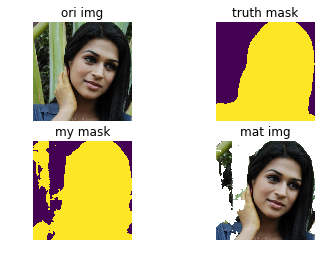

UsageError: Line magic function `%matplotlibe` not found.


In [71]:
model = UNet(3,1)
PATH = './model_big/weights_70.pth'
model.load_state_dict(torch.load(PATH,map_location='cpu'))

liver_dataset = LiverDataset()
dataloader = DataLoader(liver_dataset, 1, shuffle=True,num_workers=1)

x,y = next(iter(dataloader))
x = x.to(device, dtype=torch.float)

out =model(x)
out = (out>0.60)*1

my_result = out[0][0]

import matplotlib.pyplot as plt
import numpy as np
tmp = x[0].numpy().astype(np.uint8)
ori_image = cv2.merge([tmp[2],tmp[1],tmp[0]])

# tmp_r = (tmp.astype(np.int)[2]*(my_result.numpy())).astype(np.uint8)
# tmp_g = (tmp.astype(np.int)[1]*(my_result.numpy())).astype(np.uint8)
# tmp_b = (tmp.astype(np.int)[0]*(my_result.numpy())).astype(np.uint8)
# final = cv2.merge([tmp_r,tmp_g, tmp_b])
my_alpha = ((my_result.numpy())*255).astype(np.uint8)
final = cv2.merge([tmp[2],tmp[1],tmp[0],my_alpha])


plt.subplot(2,2,1), plt.title('ori img')
plt.imshow(ori_image), plt.axis('off')

plt.subplot(2,2,2), plt.title('truth mask')
plt.imshow(y[0].numpy()), plt.axis('off')

plt.subplot(2,2,3), plt.title('my mask')
plt.imshow(my_result.numpy()), plt.axis('off')

plt.subplot(2,2,4), plt.title('mat img')
plt.imshow(final), plt.axis('off')


plt.show()
%matplotlibe inline

In [19]:
# import matplotlib.pyplot as plt
# import numpy as np

# for sort_i in range(4):
#     my_result = out[0][sort_i]
#     tmp = x[sort_i].numpy().astype(np.uint8)
#     ori_image = cv2.merge([tmp[2],tmp[1],tmp[0]])

#     # tmp_r = (tmp.astype(np.int)[2]*(my_result.numpy())).astype(np.uint8)
#     # tmp_g = (tmp.astype(np.int)[1]*(my_result.numpy())).astype(np.uint8)
#     # tmp_b = (tmp.astype(np.int)[0]*(my_result.numpy())).astype(np.uint8)
#     # final = cv2.merge([tmp_r,tmp_g, tmp_b])
#     my_alpha = ((my_result.numpy())*255).astype(np.uint8)
#     final = cv2.merge([tmp[2],tmp[1],tmp[0],my_alpha])


#     plt.subplot(8,2,1+4*sort_i), plt.title('ori img')
#     plt.imshow(ori_image), plt.axis('off')

#     plt.subplot(8,2,2+4*sort_i), plt.title('truth mask')
#     plt.imshow(y[0].numpy()), plt.axis('off')

#     plt.subplot(8,2,3+4*sort_i), plt.title('my mask')
#     plt.imshow(my_result.numpy()), plt.axis('off')

#     plt.subplot(8,2,4+4*sort_i), plt.title('mat img')
#     plt.imshow(final), plt.axis('off')


#     plt.show()
#     %matplotlibe inline